# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
#from pylab import *
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [3]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

In [4]:
# Alternative WITHOUT FOR
"""
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
t = M_train[:,-1]
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T"""

'\nnormalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function \nt = M_train[:,-1]\nM_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST\nmoy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )\nsigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )\n\nM_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T'

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

In [5]:
# Preliminary questions
#cov = np.cov([M_train[:,k] for k in range (9)], bias=True)
cov = np.cov(M_train[:,:9].T, bias=True)

Text(0.5, 1, 'Matrice de covariance des features entre elles et avec la cible')

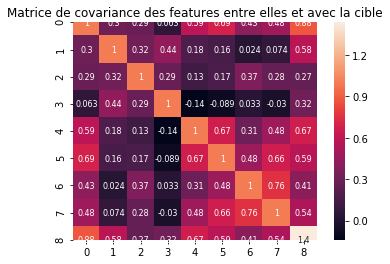

In [6]:
hm = sns.heatmap(cov,
                 cbar=True,
                 annot=True,
                 square=True,
                 #fmt='.2f',
                 annot_kws={'size': 8})
plt.title('Matrice de covariance des features entre elles et avec la cible')

On obtient des informations sur la corrélation entre les attributs pris individuellement, ainsi qu'avec la target. On voit aussi que certains attributs, correspondant aux cellules en noir, sont très peu corrélés, alors que les cellules en orange représentent des attributs très corrélés.<br>
Pour ce qui est de la corrélation des différentes features, on remarque notament que les features 7 et 8 (indexées 6 et 7) sont fortement corrélées. Concernant la target, on voit que l'attribut qui y est le plus corrélé est le premier, alors que le troisième est le moins corrélé. On pourra peut-être utiliser ces informations par la suite pour supprimer ces attributs et ainsi réduire le coût de calcul.

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [7]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,:8]), axis=1) 
# don't forget the 1st column of ones and normalization !


Formalisme du problème : <br>
* `X_train` : la matice des features avec une colone de 1 au début pour le biais/ordonnée à l'origine. Shape : (9,nb_données). <br>
* `t_train` : vecteur ligne des targets. Shape : (nb_données,1) <br> 
* `beta_hat` : vecteur colone des poids. Shape : (1,9)

In [8]:
# Exercise 1
t_train = data_train[:,8]
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train, 1)),M_train[:,:8]), axis=1)

In [9]:
beta_hat= la.inv(X_train.T@X_train)@X_train.T@t_train

In [10]:
beta_hat[0]

2.4523450850746262

`Beta_hat[0]` correspond à l'image du vecteur nul c'est à dire le coefficient du biais (ordonnée à l'origine en 2D) 

On remarque également que le coefficent le plus fort est celui de la feature 1. Cette observation reste en cohérence avec notre résultat de corrélation précédent : la feature 1 était la plus corrélée avec la target. 

Calculons notre erreur quadratique moyenne sur le jeu de test:

In [11]:
err = (X_train@beta_hat - t_train)**2
err_summ_train= np.sum(err)
print("Els sur le jeu de train :  "  + str(err_summ_train) + " soit en moyenne :  " + str(np.mean(err)))

err = (X_test@beta_hat - t_test)**2
err_summ_test = np.sum(err)
print("Els sur le jeu de test :  "  + str(err_summ_test) + " soit en moyenne :  " + str(np.mean(err)))

Els sur le jeu de train :  29.4263844599084 soit en moyenne :  0.43919976805833433
Els sur le jeu de test :  15.638220165228038 soit en moyenne :  0.5212740055076013


On observe que l'erreur est du même ordre de grandeur sur le jeu de test et le jeu d'entrainement, même si on est logiquement plus performants sur le second. <br>
En l'état il est assez difficile de savoir si cette erreur est bonne ou mauvaise. Plongeons un peu plus en détail dans les données cibles.

In [12]:
targets = data[:,8]
min=float(np.min(targets))
max = float(np.max(targets))
print(min,max)


-0.4307829 5.5829322


On a une amplitude de 6 ng/L environ pour les niveaux d'antigènes spécifiques de la prostate. Regardons comment ces valeurs sont réparties :

la moyenne des targets est de : 2.478386878350515
l'écart type des targets est de : 1.3187387513943492


Text(0.5, 1.0, 'Distribution des valeurs cibles')

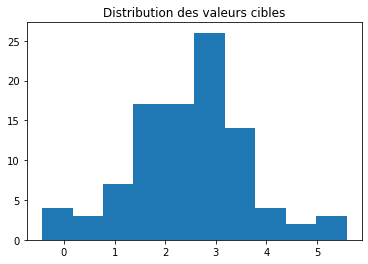

In [13]:
print("la moyenne des targets est de : " + str(np.mean(targets)))
print("l'écart type des targets est de : " + str(np.mean(targets**2)-np.mean(targets)**2))


plt.hist(targets)
plt.title('Distribution des valeurs cibles')

On voit que la répartition des targets n'est pas uniforme. Ceci montre bien qu'on ne peut pas simplement se représenter l'erreur en divisant la moyenne de $Els$ par l'amplitude des données. En effet si notre estimation (d'erreur moyenne 0.5) estime une target à 1 alors que cette dernière vaut 1.5 en réalité, c'est une grosse erreur puisque la probabilité est presque divisée par 4. <br><br>
Regardons comment l'erreur évolue en fonction de la valeur de la target.

l'écart type de l'erreur est de : 0.5781753914352767


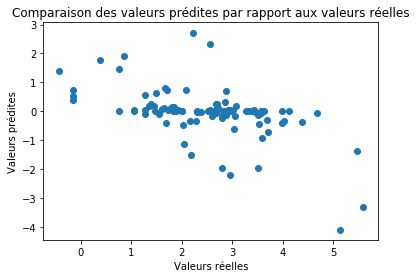

In [14]:
estim_sign = np.concatenate((np.sign(X_train@beta_hat - t_train)*(X_train@beta_hat - t_train)**2 ,np.sign(X_test@beta_hat - t_test)*(X_test@beta_hat - t_test)**2))
estim = np.concatenate(((X_train@beta_hat - t_train)**2 ,(X_test@beta_hat - t_test)**2))
t_tot = np.concatenate((t_train,t_test))

print("l'écart type de l'erreur est de : " + str(np.mean(estim**2)-np.mean(estim)**2))
plt.scatter(t_tot,estim_sign)
plt.title('Comparaison des valeurs prédites par rapport aux valeurs réelles')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()

On voit donc que le cas évoqué précédement se réalise quelques fois. On voit également que notre modèle est très précis pour les valeurs proches de la moyenne mais qu'il n'est pas précis du tout sur les valeurs extrêmes. Ceci est dû à un manque d'homogénéité dans le jeu de données. Pour résoudre le problème, il faudrait ajouter des données dans les zones moins représentées.<br><br>
L'étude de l'erreur pourrait être poursuivie. Pour ce TP, nous allons considérer que la répartition des targets suit une loi normale de moyenne 2.48 et d'écart-type 1.32. On définit alors notre erreur en pourcentages :
$$
E = \frac{Els}{N\sigma^2}
$$  

In [15]:
E = np.mean(err)/(np.mean(t_test**2)-np.mean(t_test)**2)
print("erreur de notre modèle sur le jeu de test : " + str(round(E*100,2)) + "%")

erreur de notre modèle sur le jeu de test : 49.66%


## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [16]:
beta_hat.tolist()

[2.4523450850746262,
 0.7110405922561794,
 0.29045029198643135,
 -0.14148182348942587,
 0.21041951018479588,
 0.30730025297185776,
 -0.2868407491366408,
 -0.02075686203692757,
 0.2752684254777677]

In [17]:
# Exercise 2
p=8

sigma = np.sum((X_train@beta_hat - t_train)**2)

V = np.diag(la.inv(X_train.T.dot(X_train)))

print(V.shape)
Z=[]
for k in range (9):
    Z.append(beta_hat[k]/(np.sqrt(V[k])*np.sqrt(sigma/(N_train-p-1))))
val = np.sort(np.abs(Z[:]))
print(val)
print(np.abs(Z))

(9,)
[ 0.14668121  1.39590898  1.73783972  1.86691264  2.05584563  2.46925518
  2.75078939  5.36629046 28.18152744]
[28.18152744  5.36629046  2.75078939  1.39590898  2.05584563  2.46925518
  1.86691264  0.14668121  1.73783972]


On fixe le seuil à partir duquel on considère une entrée significative à 2, conformément à l'hypothèse de simplification formulée en énoncé, ce qui nous permet d'éliminer les entrées suivantes:

In [18]:
for i in enumerate(Z):
    if(i[1]<2):
        beta_hat[i[0]] = 0


err = (X_train@beta_hat - t_train)**2
err_summ_train= np.sum(err)
print("Els sur le jeu de train :  "  + str(err_summ_train) + " soit en moyenne :  " + str(np.mean(err)))

err = (X_test@beta_hat - t_test)**2
err_summ_test = np.sum(err)
print("Els sur le jeu de test :  "  + str(err_summ_test) + " soit en moyenne :  " + str(np.mean(err)))

E = np.mean(err)/(np.mean(t_test**2)-np.mean(t_test)**2)
print("\n erreur de notre modèle sur le jeu de test : " + str(round(E*100,2)) + "%")


Els sur le jeu de train :  33.821558552664456 soit en moyenne :  0.5047993813830516
Els sur le jeu de test :  13.56679848219329 soit en moyenne :  0.45222661607310966

 erreur de notre modèle sur le jeu de test : 43.08%


En éliminant les features non significatives, on améliore légèrement la précision. Ceci pourrait être dû au fait que nous ne disposons pas de suffisamment de données pour que les coefficients des features de moindre importance soient correctement évalués. En supprimant ces coefficients de notre modèle, notre entraînement se concentre sur les features dont il est capable d'estimer l'importance, et se révèle donc plus précis lorsqu'on l'applique sur un jeu de données inconnu. En supprimant ces coefficients, nous réduisons le surapprentissage de notre modèle, qui est plus à même d'être généralisé à de nouveaux jeux de données. 

Cependant, le beta_hat actuel à été calculé sur la totalité des features. Que se passerait-il si on l'entraînait seulement sur les entrées significatives ?

In [19]:
X_train_red = X_train[:,[0,1,2,4,5]]
X_test_red = X_test[:,[0,1,2,4,5]]

inv_cov=la.inv(X_train_red.T@X_train_red)
beta_hat= inv_cov@X_train_red.T@t_train

print(beta_hat)

[2.45234509 0.62345    0.25488273 0.20339287 0.2800554 ]


In [20]:
err = (X_train_red@beta_hat - t_train)**2
err_summ_train= np.sum(err)
print("Els sur le jeu de train :  "  + str(err_summ_train) + " soit en moyenne :  " + str(np.mean(err)))

err = (X_test_red@beta_hat - t_test)**2
err_summ_test = np.sum(err)
print("Els sur le jeu de test :  "  + str(err_summ_test) + " soit en moyenne :  " + str(np.mean(err)))

E = np.mean(err)/(np.mean(t_test**2)-np.mean(t_test)**2)
print("\n erreur de notre modèle sur le jeu de test : " + str(round(E*100,2)) + "%")

Els sur le jeu de train :  32.81499474881555 soit en moyenne :  0.48977604102709776
Els sur le jeu de test :  13.689963661204882 soit en moyenne :  0.4563321220401627

 erreur de notre modèle sur le jeu de test : 43.47%


En calculant beta_hat uniquement sur les features significatives, on obtient une précision similaire, bien que très faiblement inférieure. L'intérêt est donc simplement de réduire le coût des calculs. En effet, en effectuant le calcul des Z-scores, on a été capables de supprimer des features non significatives, ce qui réduit le nombre de calculs à effectuer.

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [21]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)
N_train = data_train.shape[0]

X_train = M_train[:,:8]
t_train = M_train[:,8].reshape(N_train,1)

Lambda = 25
p = 8
t_c = t_train-t0

beta_hat_reg = la.inv(Lambda*np.identity(p) + X_train.T@X_train)@X_train.T@t_c

N_test = data_test.shape[0]
#X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  
# Here the 1st column of X_test is a column of ones.

print (beta_hat_reg)
X_test = M_test[:,:8]
t_test = M_test[:,8].reshape(N_test,1)
t_hat_reg = X_test.dot(beta_hat_reg)

[[ 0.4221092 ]
 [ 0.24879171]
 [-0.04226499]
 [ 0.16575364]
 [ 0.23091485]
 [ 0.01066329]
 [ 0.04306017]
 [ 0.13151316]]


In [22]:
err = (t_hat_reg - (t_test-t0))**2
err_summ_test = np.sum(err)
print("Els sur le jeu de test :  "  + str(err_summ_test) + " soit en moyenne :  " + str(np.mean(err)))

E = np.mean(err)/(np.mean(t_test**2)-np.mean(t_test)**2)
print("\n erreur de notre modèle sur le jeu de test : " + str(round(E*100,2)) + "%")

Els sur le jeu de test :  14.818264797356148 soit en moyenne :  0.4939421599118716

 erreur de notre modèle sur le jeu de test : 47.06%


La méthode semble bien fonctionner : le résultat est comparable aux résultats précédents. De plus, le lambda actuel à été choisi "arbitrairement" et sera amélioré en partie 4.

In [23]:
beta_best = [0.74, 0.316, 0, 0, 0 ,0 ,0, 0]
t_hat_reg = X_test.dot(beta_best)

err = (t_hat_reg - (t_test-t0))**2
err_summ_test = np.sum(err)
print("Els sur le jeu de test :  "  + str(err_summ_test) + " soit en moyenne :  " + str(np.mean(err)))

E = np.mean(err)/(np.mean(t_test**2)-np.mean(t_test)**2)
print("\n erreur de notre modèle sur le jeu de test : " + str(round(E*100,2)) + "%")

Els sur le jeu de test :  1360.7470567814073 soit en moyenne :  1.5119411742015636

 erreur de notre modèle sur le jeu de test : 144.04%


Bizarre.... le beta_best ne fonctionne pas du tout...

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [24]:
lmax = 40
lambda_pos = np.arange(0,lmax+1) 

N_test = 6
m=np.zeros(8)
s = np.zeros(8)
X_traink = np.zeros((X_train.shape[0]-N_test,8))
X_testk = np.zeros((N_test,8))
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))

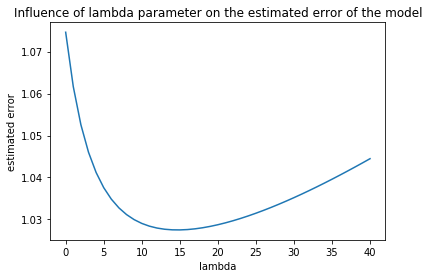

In [45]:
# Exercise 4 
for p in range(N_test):   # loop on test subsets
    # extraction of testset
    testset  = data_train[np.arange(p*N_test,(p+1)*N_test),0:9]
    # extraction of trainset
    trainset = data_train[np.hstack((np.arange(p*N_test),np.arange((p+1)*N_test,data_train.shape[0]))),0:9]

    # normalization of entries, 
    moy = np.zeros((8,))
    sigma = np.zeros((8,))
    for k in range(8): # 8 columns of entries
        moy[k]=np.mean(trainset[:,k])
        sigma[k] = np.std(trainset[:,k], ddof=0)
        trainset[:,k] = (trainset[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
        trainset[:,k] = (trainset[:,k]-moy[k])/sigma[k]   # same normalization for test set

    N_train = trainset.shape[0]
    t0 = np.mean(trainset[:,8])
    t_c = trainset[:,8].reshape(N_train,1) - t0
    X_train = trainset[:,:8]
    
    for Lambda in range (lmax+1):
        beta_hat_reg = la.inv(Lambda*np.eye(8)+X_train.T@X_train)@X_train.T@t_c
        err = np.mean((testset[:,:8]@beta_hat_reg - (testset[:,8]-t0))**2)
        erreur[p][Lambda] = err

erreur = np.array(erreur)
lambda_opti = (np.array([np.mean(erreur[:,k]) for k in range (lmax + 1)]))

l = [i for i in range (lmax+1)] 

plt.plot(l, lambda_opti)
plt.title('Influence of lambda parameter on the estimated error of the model')
plt.xlabel('lambda')
plt.ylabel('estimated error')
plt.show()

Au vu du graphique ci-dessus, on peut proposer lambda = 15. Ainsi, on trouve l'erreur la plus faible suivante :

In [50]:
np.mean(erreur[:,15])

1.027495694330446

Cette erreur est plus importante que dans l'exercice précédent, alors que le but de cet exercice était de la réduire en optimisant la valeur de lambda. Il semble donc y avoir une erreur dans notre calcul que nous ne sommes pas parvenus à corriger.

In [58]:
# Exercise 4 ---------------
# ...
# averaged error on the 6 training/test sets ?
erreur_lambda = np.mean(erreur,axis=0)
# standard variation of this error estimate ?
std_erreur_lambda = np.std(erreur_lambda)
print(erreur_lambda, std_erreur_lambda, std_erreur_lambda/np.mean(erreur_lambda))


[1.07461409 1.06165838 1.05257304 1.04601934 1.04118853 1.03757012
 1.03483002 1.03274273 1.03115198 1.02994693 1.02904733 1.02839396
 1.02794236 1.02765867 1.02751664 1.02749569 1.02757948 1.0277548
 1.02801092 1.02833899 1.02873161 1.02918255 1.02968654 1.030239
 1.03083599 1.03147407 1.03215017 1.03286161 1.03360596 1.03438104
 1.03518488 1.03601569 1.03687183 1.03775178 1.03865416 1.03957767
 1.04052112 1.04148339 1.04246344 1.04346028 1.044473  ] 0.00958719613072187 0.009255000361109293


L'écart-type ne semble a priori pas très important, mais il est assez aisé de voir, notamment grâce à la courbe tracée ci-dessus, que l'erreur atteint un minimum pour un certain lambda qu'il peut donc se révéler être utile de calculer.


L'erreur obtenue ici est cependant deux fois plus importante que dans l'exercice trois ci-dessus. Il semble donc qu'il y ait eu une erreur de programmation dans notre code que nous ne sommes pas parvenus à corriger.